Clustering from CSV file

Using device: cpu
Configured LABEL rank range: 1 .. 10000 (1-based, inclusive)
MIN_SPECTRA_PER_LABEL = 100
MAX_SPECTRA_PER_LABEL = 1000

Loading CSV: F:\20251201\ms2.csv
Found 1600 MS2 columns: ['cast_00000', 'cast_00001', 'cast_00002', 'cast_00003', 'cast_00004'] ...
Total rows in CSV: 19307
Rows with non-empty Accession (used for supervised training): 4485
Any NaN left in ms2_lib? False
Any inf left in ms2_lib? False
Spectra shape before per-label construction: (N, n_bins) = (4485, 1600)
Example raw labels (Accession): ['P05204' 'Q9Y2I7-2' 'P02686-5' 'P02686-5' 'P02686-5']

Applying per-label limits:
Labels dropped for having < 100 spectra: 58
Labels capped at 1000 spectra: 1
Total spectra after per-label MIN/MAX filter: 3343
Spectra shape after per-label MIN/MAX: (N, n_bins) = (3343, 1600)
Total unique labels before rank-frequency filter: 11

Using LABEL ranks 1..11 (1-based).
Number of LABEL classes in this block: 11
Spectra after LABEL-block (rank) filter: 3343
Number of unique LA

c:\Users\benja\miniconda3\envs\vae\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


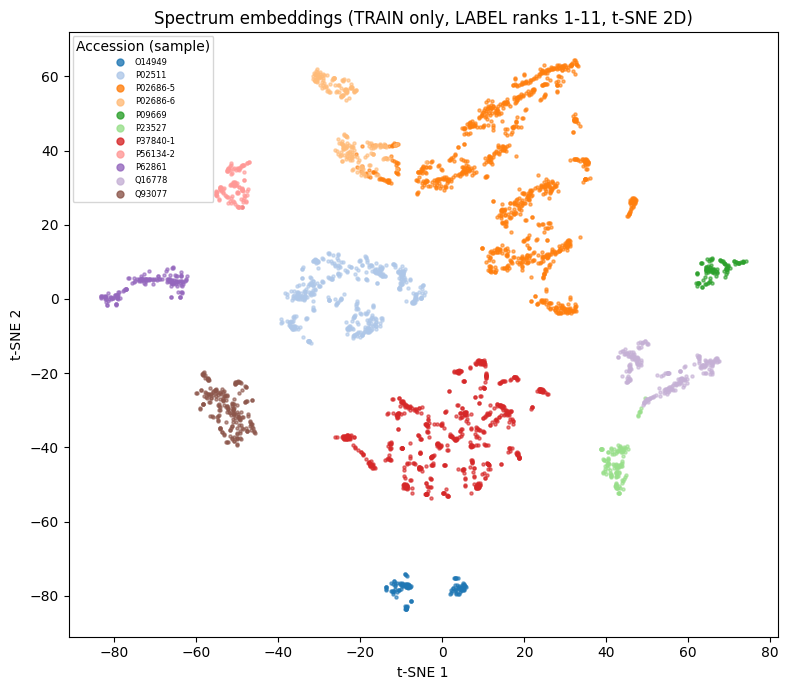

In [6]:
"""
Contrastive spectrum → Accession search engine on CSV (no test split)

Data format:
- CSV file with columns:
    - cast_0000 ... cast_01599  -> MS2 spectra intensities (float)
    - Accession                 -> label (string, may be empty/NaN for unidentified)

Pipeline:
    1. Load & clean CSV
    2. Keep only rows with non-empty Accession (identified)
    3. Per-spectrum max normalization on cast_* columns
    4. Build labels = Accession strings
    5. Enforce MIN/MAX spectra per label
    6. Restrict to configured label frequency rank range
    7. Use all remaining spectra for training (no test split)
    8. Train supervised contrastive encoder
    9. Build train embedding index
   10. t-SNE on TRAIN embeddings (with legends)
   11. Save model with rank range in filename
"""

import os
import numpy as np
from collections import defaultdict

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# =========================
# 0. Config
# =========================
CSV_PATH        = r"F:\20251201\ms2.csv"  # <-- UPDATED
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"

EMB_DIM         = 64           # embedding dimension
BATCH_P_CLASSES = 32           # number of labels per batch
BATCH_K_SPECTRA = 4            # spectra per label per batch
EPOCHS          = 100
LR              = 1e-3
TEMPERATURE     = 0.07

RANDOM_SEED     = 42

# ---- per-label controls ----
MAX_SPECTRA_PER_LABEL = 1000    # hard cap per label
MIN_SPECTRA_PER_LABEL = 100     # drop labels with fewer than this

# ---- configurable label frequency rank range (1-based) ----
START_RANK      = 1            # e.g. 51
END_RANK        = 10000        # e.g. 100

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Using device:", DEVICE)
print(f"Configured LABEL rank range: {START_RANK} .. {END_RANK} (1-based, inclusive)")
print(f"MIN_SPECTRA_PER_LABEL = {MIN_SPECTRA_PER_LABEL}")
print(f"MAX_SPECTRA_PER_LABEL = {MAX_SPECTRA_PER_LABEL}")


# =========================
# 1. Load CSV & initial clean
# =========================
print("\nLoading CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH)

# Identify MS2 columns: cast_0000..cast_01599
ms2_cols = [col for col in df.columns if col.startswith("cast_")]
if len(ms2_cols) == 0:
    raise ValueError("No columns starting with 'cast_' found in CSV.")

ms2_cols = sorted(ms2_cols)  # ensure correct order cast_0000, cast_0001, ...

print(f"Found {len(ms2_cols)} MS2 columns:", ms2_cols[:5], "...")

# Labels from 'Accession'
if "Accession" not in df.columns:
    raise ValueError("CSV does not contain 'Accession' column.")

accession_raw = df["Accession"]

# Keep only rows with non-empty Accession (identified)
mask_identified = accession_raw.notna() & (accession_raw.astype(str).str.strip() != "")
df_id = df[mask_identified].reset_index(drop=True)
accession = df_id["Accession"].astype(str).str.strip().values

print("Total rows in CSV:", len(df))
print("Rows with non-empty Accession (used for supervised training):", len(df_id))

if len(df_id) == 0:
    raise ValueError("No rows with non-empty Accession. Cannot run supervised contrastive training.")

# Extract MS2 intensities
ms2_lib = df_id[ms2_cols].values.astype(np.float32)

# Replace NaN/inf in ms2 with 0
bad_mask = ~np.isfinite(ms2_lib)
if bad_mask.any():
    print("Found NaN/inf in ms2_lib, replacing with 0")
    ms2_lib[bad_mask] = 0.0

# Per-spectrum max normalization
max_intensity = np.max(ms2_lib, axis=1, keepdims=True)
max_intensity[max_intensity == 0] = 1.0
ms2_lib = ms2_lib / max_intensity

print("Any NaN left in ms2_lib?", np.isnan(ms2_lib).any())
print("Any inf left in ms2_lib?", np.isinf(ms2_lib).any())

N_total, n_bins = ms2_lib.shape
print(f"Spectra shape before per-label construction: (N, n_bins) = {ms2_lib.shape}")


# =========================
# 2. Build label = Accession string and enforce MIN/MAX per label
# =========================
label_str = np.array(accession, dtype=object)
print("Example raw labels (Accession):", label_str[:5])

# ---- enforce MIN/MAX spectra per label BEFORE rank filtering ----
print("\nApplying per-label limits:")
label_to_indices = defaultdict(list)
for i, lab in enumerate(label_str):
    label_to_indices[lab].append(i)

keep_indices = []
dropped_too_few = 0
capped_too_many = 0

for lab, idxs in label_to_indices.items():
    n = len(idxs)
    if n < MIN_SPECTRA_PER_LABEL:
        dropped_too_few += 1
        continue  # drop this label entirely
    if n > MAX_SPECTRA_PER_LABEL:
        capped_too_many += 1
        chosen = np.random.choice(idxs, size=MAX_SPECTRA_PER_LABEL, replace=False)
        keep_indices.extend(chosen.tolist())
    else:
        keep_indices.extend(idxs)

keep_indices = np.array(keep_indices, dtype=int)

print(f"Labels dropped for having < {MIN_SPECTRA_PER_LABEL} spectra: {dropped_too_few}")
print(f"Labels capped at {MAX_SPECTRA_PER_LABEL} spectra: {capped_too_many}")
print("Total spectra after per-label MIN/MAX filter:", len(keep_indices))

if len(keep_indices) == 0:
    raise ValueError(
        "No spectra left after applying MIN_SPECTRA_PER_LABEL and MAX_SPECTRA_PER_LABEL. "
        "Relax thresholds or check dataset."
    )

# Apply per-label filter
ms2_lib   = ms2_lib[keep_indices]
label_str = label_str[keep_indices]

N_total, n_bins = ms2_lib.shape
print(f"Spectra shape after per-label MIN/MAX: (N, n_bins) = {ms2_lib.shape}")


# =========================
# 3. Restrict to chosen LABEL rank range (frequency-based)
# =========================
all_unique_lbl, all_lbl_ids = np.unique(label_str, return_inverse=True)
counts = np.bincount(all_lbl_ids)
print("Total unique labels before rank-frequency filter:", len(all_unique_lbl))

# Sort labels by frequency (descending)
sorted_class_indices = np.argsort(-counts)  # 0..(n_classes-1), high→low frequency
n_classes_total = len(sorted_class_indices)

# Clip requested rank range to available classes
start_rank = max(1, START_RANK)
end_rank   = min(END_RANK, n_classes_total)

if end_rank < start_rank:
    raise ValueError(
        f"No valid LABEL ranks after clipping to available classes. "
        f"Requested {START_RANK}-{END_RANK}, available 1-{n_classes_total}."
    )

start_idx = start_rank - 1  # inclusive
end_idx   = end_rank        # exclusive in slicing

block_indices = sorted_class_indices[start_idx:end_idx]
print(f"\nUsing LABEL ranks {start_rank}..{end_rank} (1-based).")
print(f"Number of LABEL classes in this block: {len(block_indices)}")

if len(block_indices) == 0:
    raise ValueError(
        "No LABEL classes in the requested rank range. "
        "Try a different range (e.g. 1..50)."
    )

block_set = set(block_indices.tolist())

# Filter spectra to only these labels
mask_block        = np.isin(all_lbl_ids, list(block_set))
label_str_block   = label_str[mask_block]
ms2_lib_block     = ms2_lib[mask_block]
lbl_ids_block_raw = all_lbl_ids[mask_block]

print("Spectra after LABEL-block (rank) filter:", len(label_str_block))

# Re-encode LABELs compactly 0..(K-1)
unique_lbl_block, lbl_ids_block = np.unique(label_str_block, return_inverse=True)
unique_lbl_block = np.array(unique_lbl_block, dtype=object)
n_classes = len(unique_lbl_block)
print("Number of unique LABELs in block:", n_classes)

N, n_bins = ms2_lib_block.shape
print(f"Final spectra shape after LABEL block filter: (N, n_bins) = {ms2_lib_block.shape}")


# =========================
# 4. Use ALL filtered spectra as training data (NO test split)
# =========================
train_ms2   = ms2_lib_block
train_lblid = lbl_ids_block

print(f"\nTraining on ALL spectra after filtering: {len(train_ms2)}")


# =========================
# 5. Dataset & balanced sampler
# =========================
class SpectraDataset(Dataset):
    def __init__(self, ms2, labels):
        self.ms2    = torch.tensor(ms2,   dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.ms2.shape[0]

    def __getitem__(self, idx):
        return {
            "spectrum": self.ms2[idx],
            "label":    self.labels[idx]
        }


class ClassBalancedBatchSampler(Sampler):
    """
    Samples batches with:
      - classes_per_batch distinct labels
      - samples_per_class spectra for each label
    """
    def __init__(self, labels, classes_per_batch=32, samples_per_class=4):
        self.labels = np.array(labels, dtype=np.int64)
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class

        self.class_to_indices = defaultdict(list)
        for i, lab in enumerate(self.labels):
            self.class_to_indices[lab].append(i)

        self.unique_classes = np.array(list(self.class_to_indices.keys()))
        self.batch_size = self.classes_per_batch * self.samples_per_class

    def __iter__(self):
        while True:
            if len(self.unique_classes) <= self.classes_per_batch:
                chosen_classes = self.unique_classes
            else:
                chosen_classes = np.random.choice(
                    self.unique_classes,
                    size=self.classes_per_batch,
                    replace=False
                )

            batch_indices = []
            for c in chosen_classes:
                idxs = self.class_to_indices[c]
                if len(idxs) >= self.samples_per_class:
                    chosen = np.random.choice(idxs, size=self.samples_per_class, replace=False)
                else:
                    chosen = np.random.choice(idxs, size=self.samples_per_class, replace=True)
                batch_indices.extend(chosen.tolist())
            yield batch_indices

    def __len__(self):
        # approximate number of batches per epoch
        return max(1, len(self.labels) // self.batch_size)


train_dataset = SpectraDataset(train_ms2, train_lblid)
train_sampler = ClassBalancedBatchSampler(
    labels=train_lblid,
    classes_per_batch=BATCH_P_CLASSES,
    samples_per_class=BATCH_K_SPECTRA
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler
)


# =========================
# 6. Model
# =========================
class SpectrumEncoder(nn.Module):
    def __init__(self, n_bins, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bins, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, emb_dim),
        )

    def forward(self, x):
        z = self.net(x)
        if torch.isnan(z).any():
            print("Warning: NaN detected in encoder output, applying nan_to_num.")
            z = torch.nan_to_num(z, nan=0.0, posinf=1e6, neginf=-1e6)
        z = F.normalize(z, dim=-1)
        return z


# =========================
# 7. Safe supervised contrastive loss
# =========================
def supervised_contrastive_loss_safe(emb, labels, temperature=0.07):
    """
    emb    : (B, D) L2-normalized embeddings
    labels : (B,) int label ids
    """
    device = emb.device
    B, D = emb.shape
    if B <= 1:
        return torch.tensor(0.0, device=device)

    # Cosine similarity
    sim = emb @ emb.t()
    sim = torch.clamp(sim / temperature, min=-50.0, max=50.0)

    total_loss = 0.0
    valid_anchors = 0

    for i in range(B):
        sim_i = sim[i].clone()
        sim_i[i] = float("-inf")

        pos_mask_i = (labels == labels[i]) & (torch.arange(B, device=device) != i)
        if not pos_mask_i.any():
            continue

        finite_mask = torch.isfinite(sim_i)
        if not finite_mask.any():
            continue

        max_sim = sim_i[finite_mask].max()
        shifted = sim_i - max_sim
        shifted[~finite_mask] = float("-inf")

        exp_all = torch.exp(shifted)
        denom = exp_all.sum()
        if not torch.isfinite(denom) or denom <= 0:
            continue

        exp_pos = exp_all * pos_mask_i.float()
        num = exp_pos.sum()
        if not torch.isfinite(num) or num <= 0:
            continue

        loss_i = -torch.log(num / denom)
        if not torch.isfinite(loss_i):
            continue

        total_loss += loss_i
        valid_anchors += 1

    if valid_anchors == 0:
        return torch.tensor(0.0, device=device)

    loss = total_loss / valid_anchors
    return loss


# =========================
# 8. Training loop
# =========================
model = SpectrumEncoder(n_bins=n_bins, emb_dim=EMB_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

steps_per_epoch = len(train_loader)
print("\nsteps_per_epoch:", steps_per_epoch)

# Sanity check
print("Running a sanity check on one batch...")
batch_example = next(iter(train_loader))
x_ex = batch_example["spectrum"].to(DEVICE)
y_ex = batch_example["label"].to(DEVICE)
with torch.no_grad():
    emb_ex = model(x_ex)
    print("Any NaN in emb_ex?", torch.isnan(emb_ex).any().item())
    loss_ex = supervised_contrastive_loss_safe(emb_ex, y_ex, temperature=TEMPERATURE)
    print("Initial loss (sanity check):", loss_ex.item())

print("\nStarting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    effective_steps = 0

    for step, batch in enumerate(train_loader):
        if step >= steps_per_epoch:
            break  # prevent infinite epoch

        x = batch["spectrum"].to(DEVICE)
        y = batch["label"].to(DEVICE)

        emb = model(x)
        loss = supervised_contrastive_loss_safe(emb, y, temperature=TEMPERATURE)

        if torch.isnan(loss) or not torch.isfinite(loss):
            print(f"NaN/inf loss at epoch {epoch+1}, step {step+1}. Skipping.")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        effective_steps += 1

        if (step + 1) % 100 == 0:
            avg_loss = running_loss / max(1, effective_steps)
            print(f"Epoch {epoch+1} Step {step+1}/{steps_per_epoch}  Loss: {avg_loss:.4f}")

    avg_loss = running_loss / max(1, effective_steps)
    print(f"Epoch {epoch+1} completed. Avg loss over valid steps: {avg_loss:.4f}")

print("Training done.")


# =========================
# 9. Build train embedding index
# =========================
model.eval()
with torch.no_grad():
    train_emb = []
    batch_size_eval = 2048
    for i in range(0, len(train_ms2), batch_size_eval):
        batch = torch.tensor(
            train_ms2[i:i+batch_size_eval],
            dtype=torch.float32,
            device=DEVICE
        )
        z = model(batch)
        train_emb.append(z.cpu().numpy())
    train_emb = np.concatenate(train_emb, axis=0)

print("\nTrain embeddings shape:", train_emb.shape)
train_labels = train_lblid


# =========================
# 10. Save model
# =========================
MODEL_PATH = (
    f"contrastive_spectrum_encoder_Accession_"
    f"min{MIN_SPECTRA_PER_LABEL}_max{MAX_SPECTRA_PER_LABEL}_"
    f"ranks_{start_rank}_{end_rank}.pth"
)

torch.save({
    "model_state_dict": model.state_dict(),
    "emb_dim": EMB_DIM,
    "n_bins": n_bins,
    "unique_label_block": list(unique_lbl_block),  # accession labels for this block
    "rank_start": start_rank,
    "rank_end": end_rank,
    "min_spectra_per_label": MIN_SPECTRA_PER_LABEL,
    "max_spectra_per_label": MAX_SPECTRA_PER_LABEL,
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")


# =========================
# 11. Embedding visualization: t-SNE on TRAIN embeddings (WITH LEGEND)
# =========================
N_TOTAL = train_emb.shape[0]
N_VIS   = 8000   # how many points to visualize

if N_TOTAL <= N_VIS:
    vis_idx = np.arange(N_TOTAL)
else:
    vis_idx = np.random.choice(N_TOTAL, size=N_VIS, replace=False)

X_train = train_emb[vis_idx]        # (N_vis, emb_dim)
y_train = train_labels[vis_idx]     # (N_vis,)

print(f"\nVisualizing TRAIN: {X_train.shape[0]} points out of {N_TOTAL} total (t-SNE).")

print("PCA to 50D before t-SNE (TRAIN)...")
pca_50 = PCA(n_components=min(50, X_train.shape[1]), random_state=42)
X_train_50 = pca_50.fit_transform(X_train)

print("Running t-SNE on TRAIN...")
tsne_train = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init="random",
    random_state=42,
)
X_train_tsne = tsne_train.fit_transform(X_train_50)

# color map helper
cmap = plt.get_cmap("tab20")
def label_to_color(label_id: int):
    return cmap(label_id % 20)

# Plot TRAIN t-SNE with legend (cap legend to first 20 labels to avoid clutter)
plt.figure(figsize=(8, 7))
unique_labs_train = np.unique(y_train)

max_labels_in_legend = 20
legend_handles = []
legend_labels  = []

for i, lab in enumerate(unique_labs_train):
    mask = (y_train == lab)
    color = label_to_color(lab)
    acc_name = str(unique_lbl_block[lab])
    plt.scatter(
        X_train_tsne[mask, 0],
        X_train_tsne[mask, 1],
        s=5,
        alpha=0.6,
        c=[color],
    )
    # Only put the first few into legend to keep it readable
    if i < max_labels_in_legend:
        handle = plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            markersize=5,
            alpha=0.8
        )
        handle.set_color(color)
        legend_handles.append(handle)
        legend_labels.append(acc_name)

plt.title(f"Spectrum embeddings (TRAIN only, LABEL ranks {start_rank}-{end_rank}, t-SNE 2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
if legend_handles:
    plt.legend(
        legend_handles,
        legend_labels,
        title="Accession (sample)",
        loc="best",
        fontsize=6
    )
plt.tight_layout()
plt.show()


Prediction of unidentifed PFRs from CSV file

Using device: cpu
Configured LABEL rank range: 1 .. 10000 (1-based, inclusive)
MIN_SPECTRA_PER_LABEL = 100
MAX_SPECTRA_PER_LABEL = 1000

Loading CSV: F:\20251201\ms2.csv
Found 1600 MS2 columns: ['cast_00000', 'cast_00001', 'cast_00002', 'cast_00003', 'cast_00004'] ...
Total rows in CSV: 19307
Identified rows   : 4485
Unidentified rows : 14822
Identified ms2: any NaN? False any inf? False
Unidentified ms2: any NaN? False any inf? False
Identified spectra shape before per-label construction: (N, n_bins) = (4485, 1600)
Example raw labels (Accession): ['P05204' 'Q9Y2I7-2' 'P02686-5' 'P02686-5' 'P02686-5']

Applying per-label limits:
Labels dropped for having < 100 spectra: 58
Labels capped at 1000 spectra: 1
Total identified spectra after per-label MIN/MAX filter: 3343
Identified spectra shape after per-label MIN/MAX: (N, n_bins) = (3343, 1600)
Total unique labels before rank-frequency filter: 11

Using LABEL ranks 1..11 (1-based).
Number of LABEL classes in this block: 11
Identified spect

c:\Users\benja\miniconda3\envs\vae\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


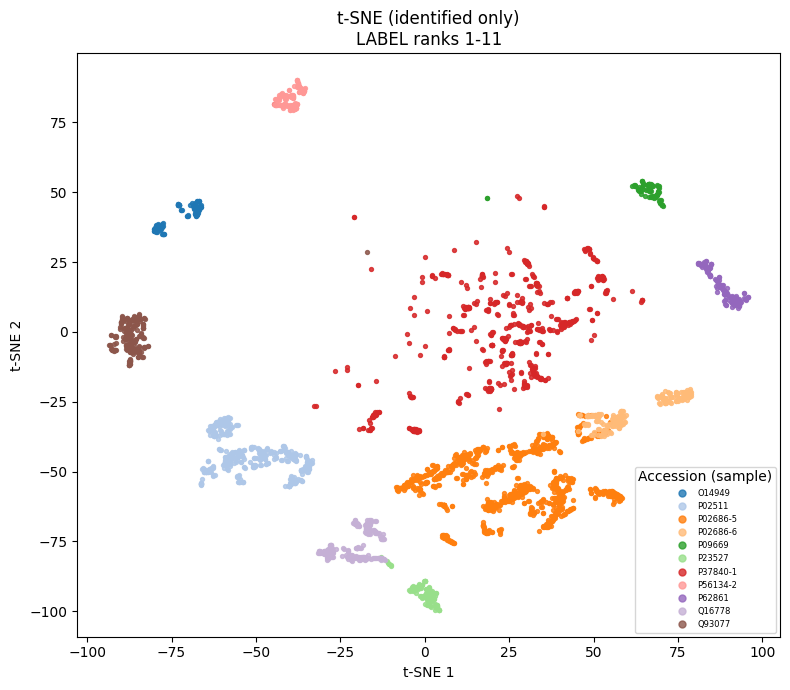

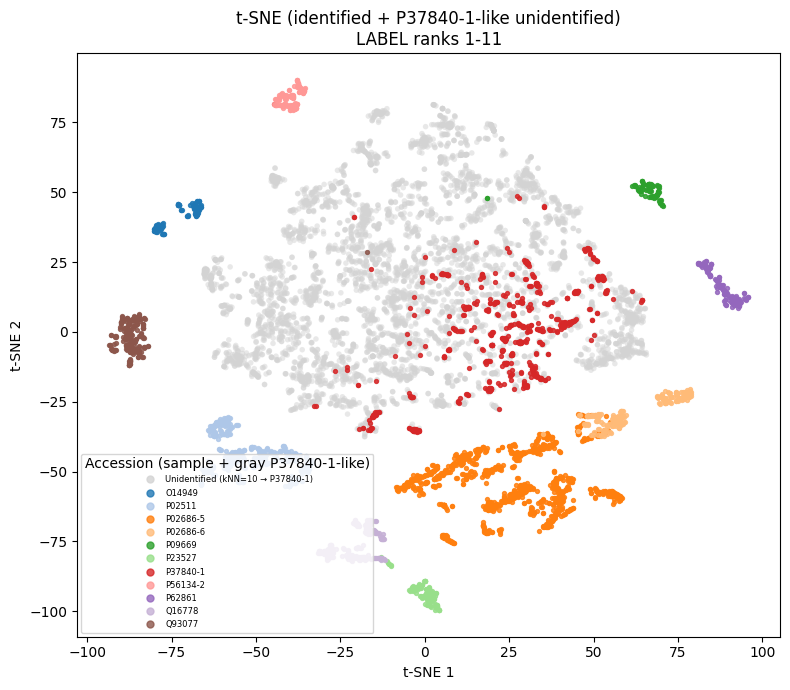

In [10]:
"""
Contrastive spectrum → Accession search engine on CSV (no test split)

Data format:
- CSV file with columns:
    - cast_0000 ... cast_01599  -> MS2 spectra intensities (float)
    - Accession                 -> label (string; empty/NaN = unidentified)

Pipeline:
    1. Load & clean CSV
    2. Split into identified (non-empty Accession) and unidentified (empty/NaN)
    3. Per-spectrum max normalization on cast_* columns (separately for each group)
    4. For identified: build labels = Accession strings
    5. Enforce MIN/MAX spectra per label
    6. Restrict to configured label frequency rank range
    7. Use all remaining identified spectra for training (no test split)
    8. Train supervised contrastive encoder
    9. Build train embedding index (identified)
   10. Embed unidentified spectra with trained model
   11. k-NN (k=10) for unidentified vs identified; keep only those with majority label P37840-1
   12. Joint t-SNE on identified + selected unidentified
   13. Plot t-SNE BEFORE (identified only) and AFTER (identified + gray cloud for P37840-1-like unidentified)
"""

import os
import numpy as np
from collections import defaultdict

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# =========================
# 0. Config
# =========================
CSV_PATH        = r"F:\20251201\ms2.csv"
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"

EMB_DIM         = 64           # embedding dimension
BATCH_P_CLASSES = 32           # number of labels per batch
BATCH_K_SPECTRA = 4            # spectra per label per batch
EPOCHS          = 100
LR              = 1e-3
TEMPERATURE     = 0.07

RANDOM_SEED     = 42

# ---- per-label controls ----
MAX_SPECTRA_PER_LABEL = 1000    # hard cap per label
MIN_SPECTRA_PER_LABEL = 100      # drop labels with fewer than this

# ---- configurable label frequency rank range (1-based) ----
START_RANK      = 1
END_RANK        = 10000

# ---- kNN target ----
TARGET_LABEL    = "P37840-1"   # accession of interest for gray cloud
K_NEIGHBORS     = 10

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Using device:", DEVICE)
print(f"Configured LABEL rank range: {START_RANK} .. {END_RANK} (1-based, inclusive)")
print(f"MIN_SPECTRA_PER_LABEL = {MIN_SPECTRA_PER_LABEL}")
print(f"MAX_SPECTRA_PER_LABEL = {MAX_SPECTRA_PER_LABEL}")


# =========================
# 1. Load CSV & split identified / unidentified
# =========================
print("\nLoading CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH)

# Identify MS2 columns: cast_0000..cast_01599
ms2_cols = [col for col in df.columns if col.startswith("cast_")]
if len(ms2_cols) == 0:
    raise ValueError("No columns starting with 'cast_' found in CSV.")

ms2_cols = sorted(ms2_cols)  # ensure correct order cast_0000, cast_0001, ...

print(f"Found {len(ms2_cols)} MS2 columns:", ms2_cols[:5], "...")

# Accession column
if "Accession" not in df.columns:
    raise ValueError("CSV does not contain 'Accession' column.")

acc_series = df["Accession"]
acc_str = acc_series.astype(str).str.strip()

# Unidentified = empty row or NaN
mask_unidentified = acc_series.isna() | (acc_str == "")
mask_identified   = ~mask_unidentified

df_id   = df[mask_identified].reset_index(drop=True)   # identified
df_unid = df[mask_unidentified].reset_index(drop=True) # unidentified (candidate gray cloud)

print("Total rows in CSV:", len(df))
print("Identified rows   :", len(df_id))
print("Unidentified rows :", len(df_unid))

if len(df_id) == 0:
    raise ValueError("No rows with non-empty Accession. Cannot run supervised contrastive training.")

# ------------------------
# Identified spectra
# ------------------------
accession = df_id["Accession"].astype(str).str.strip().values
ms2_id = df_id[ms2_cols].values.astype(np.float32)

bad_mask_id = ~np.isfinite(ms2_id)
if bad_mask_id.any():
    print("Found NaN/inf in identified ms2, replacing with 0")
    ms2_id[bad_mask_id] = 0.0

max_intensity_id = np.max(ms2_id, axis=1, keepdims=True)
max_intensity_id[max_intensity_id == 0] = 1.0
ms2_id = ms2_id / max_intensity_id

print("Identified ms2: any NaN?", np.isnan(ms2_id).any(), "any inf?", np.isinf(ms2_id).any())

# ------------------------
# Unidentified spectra (for later kNN + overlay)
# ------------------------
if len(df_unid) > 0:
    ms2_unlabeled = df_unid[ms2_cols].values.astype(np.float32)

    bad_mask_unid = ~np.isfinite(ms2_unlabeled)
    if bad_mask_unid.any():
        print("Found NaN/inf in unidentified ms2, replacing with 0")
        ms2_unlabeled[bad_mask_unid] = 0.0

    max_intensity_unid = np.max(ms2_unlabeled, axis=1, keepdims=True)
    max_intensity_unid[max_intensity_unid == 0] = 1.0
    ms2_unlabeled = ms2_unlabeled / max_intensity_unid

    print("Unidentified ms2: any NaN?", np.isnan(ms2_unlabeled).any(),
          "any inf?", np.isinf(ms2_unlabeled).any())
else:
    ms2_unlabeled = np.zeros((0, len(ms2_cols)), dtype=np.float32)

N_total_id, n_bins = ms2_id.shape
print(f"Identified spectra shape before per-label construction: (N, n_bins) = {ms2_id.shape}")


# =========================
# 2. Build label = Accession string and enforce MIN/MAX per label
# =========================
label_str = np.array(accession, dtype=object)
print("Example raw labels (Accession):", label_str[:5])

print("\nApplying per-label limits:")
label_to_indices = defaultdict(list)
for i, lab in enumerate(label_str):
    label_to_indices[lab].append(i)

keep_indices = []
dropped_too_few = 0
capped_too_many = 0

for lab, idxs in label_to_indices.items():
    n = len(idxs)
    if n < MIN_SPECTRA_PER_LABEL:
        dropped_too_few += 1
        continue
    if n > MAX_SPECTRA_PER_LABEL:
        capped_too_many += 1
        chosen = np.random.choice(idxs, size=MAX_SPECTRA_PER_LABEL, replace=False)
        keep_indices.extend(chosen.tolist())
    else:
        keep_indices.extend(idxs)

keep_indices = np.array(keep_indices, dtype=int)

print(f"Labels dropped for having < {MIN_SPECTRA_PER_LABEL} spectra: {dropped_too_few}")
print(f"Labels capped at {MAX_SPECTRA_PER_LABEL} spectra: {capped_too_many}")
print("Total identified spectra after per-label MIN/MAX filter:", len(keep_indices))

if len(keep_indices) == 0:
    raise ValueError(
        "No spectra left after applying MIN_SPECTRA_PER_LABEL and MAX_SPECTRA_PER_LABEL. "
        "Relax thresholds or check dataset."
    )

# Apply filter to identified set
ms2_lib   = ms2_id[keep_indices]
label_str = label_str[keep_indices]

N_total_id, n_bins = ms2_lib.shape
print(f"Identified spectra shape after per-label MIN/MAX: (N, n_bins) = {ms2_lib.shape}")


# =========================
# 3. Restrict to chosen LABEL rank range (frequency-based)
# =========================
all_unique_lbl, all_lbl_ids = np.unique(label_str, return_inverse=True)
counts = np.bincount(all_lbl_ids)
print("Total unique labels before rank-frequency filter:", len(all_unique_lbl))

sorted_class_indices = np.argsort(-counts)  # high→low frequency
n_classes_total = len(sorted_class_indices)

start_rank = max(1, START_RANK)
end_rank   = min(END_RANK, n_classes_total)

if end_rank < start_rank:
    raise ValueError(
        f"No valid LABEL ranks after clipping to available classes. "
        f"Requested {START_RANK}-{END_RANK}, available 1-{n_classes_total}."
    )

start_idx = start_rank - 1
end_idx   = end_rank

block_indices = sorted_class_indices[start_idx:end_idx]
print(f"\nUsing LABEL ranks {start_rank}..{end_rank} (1-based).")
print(f"Number of LABEL classes in this block: {len(block_indices)}")

if len(block_indices) == 0:
    raise ValueError(
        "No LABEL classes in the requested rank range. "
        "Try a different range (e.g. 1..50)."
    )

block_set = set(block_indices.tolist())

mask_block        = np.isin(all_lbl_ids, list(block_set))
label_str_block   = label_str[mask_block]
ms2_lib_block     = ms2_lib[mask_block]
lbl_ids_block_raw = all_lbl_ids[mask_block]

print("Identified spectra after LABEL-block (rank) filter:", len(label_str_block))

unique_lbl_block, lbl_ids_block = np.unique(label_str_block, return_inverse=True)
unique_lbl_block = np.array(unique_lbl_block, dtype=object)
n_classes = len(unique_lbl_block)
print("Number of unique LABELs in block:", n_classes)

N, n_bins = ms2_lib_block.shape
print(f"Final identified spectra shape after LABEL block filter: (N, n_bins) = {ms2_lib_block.shape}")


# =========================
# 4. Use ALL filtered identified spectra as training data (NO test split)
# =========================
train_ms2   = ms2_lib_block
train_lblid = lbl_ids_block

print(f"\nTraining on ALL identified spectra after filtering: {len(train_ms2)}")


# =========================
# 5. Dataset & balanced sampler
# =========================
class SpectraDataset(Dataset):
    def __init__(self, ms2, labels):
        self.ms2    = torch.tensor(ms2,   dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.ms2.shape[0]

    def __getitem__(self, idx):
        return {
            "spectrum": self.ms2[idx],
            "label":    self.labels[idx]
        }


class ClassBalancedBatchSampler(Sampler):
    """
    Samples batches with:
      - classes_per_batch distinct labels
      - samples_per_class spectra for each label
    """
    def __init__(self, labels, classes_per_batch=32, samples_per_class=4):
        self.labels = np.array(labels, dtype=np.int64)
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class

        self.class_to_indices = defaultdict(list)
        for i, lab in enumerate(self.labels):
            self.class_to_indices[lab].append(i)

        self.unique_classes = np.array(list(self.class_to_indices.keys()))
        self.batch_size = self.classes_per_batch * self.samples_per_class

    def __iter__(self):
        while True:
            if len(self.unique_classes) <= self.classes_per_batch:
                chosen_classes = self.unique_classes
            else:
                chosen_classes = np.random.choice(
                    self.unique_classes,
                    size=self.classes_per_batch,
                    replace=False
                )

            batch_indices = []
            for c in chosen_classes:
                idxs = self.class_to_indices[c]
                if len(idxs) >= self.samples_per_class:
                    chosen = np.random.choice(idxs, size=self.samples_per_class, replace=False)
                else:
                    chosen = np.random.choice(idxs, size=self.samples_per_class, replace=True)
                batch_indices.extend(chosen.tolist())
            yield batch_indices

    def __len__(self):
        return max(1, len(self.labels) // self.batch_size)


train_dataset = SpectraDataset(train_ms2, train_lblid)
train_sampler = ClassBalancedBatchSampler(
    labels=train_lblid,
    classes_per_batch=BATCH_P_CLASSES,
    samples_per_class=BATCH_K_SPECTRA
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler
)


# =========================
# 6. Model
# =========================
class SpectrumEncoder(nn.Module):
    def __init__(self, n_bins, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bins, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, emb_dim),
        )

    def forward(self, x):
        z = self.net(x)
        if torch.isnan(z).any():
            print("Warning: NaN detected in encoder output, applying nan_to_num.")
            z = torch.nan_to_num(z, nan=0.0, posinf=1e6, neginf=-1e6)
        z = F.normalize(z, dim=-1)
        return z


# =========================
# 7. Safe supervised contrastive loss
# =========================
def supervised_contrastive_loss_safe(emb, labels, temperature=0.07):
    device = emb.device
    B, D = emb.shape
    if B <= 1:
        return torch.tensor(0.0, device=device)

    sim = emb @ emb.t()
    sim = torch.clamp(sim / temperature, min=-50.0, max=50.0)

    total_loss = 0.0
    valid_anchors = 0

    for i in range(B):
        sim_i = sim[i].clone()
        sim_i[i] = float("-inf")

        pos_mask_i = (labels == labels[i]) & (torch.arange(B, device=device) != i)
        if not pos_mask_i.any():
            continue

        finite_mask = torch.isfinite(sim_i)
        if not finite_mask.any():
            continue

        max_sim = sim_i[finite_mask].max()
        shifted = sim_i - max_sim
        shifted[~finite_mask] = float("-inf")

        exp_all = torch.exp(shifted)
        denom = exp_all.sum()
        if not torch.isfinite(denom) or denom <= 0:
            continue

        exp_pos = exp_all * pos_mask_i.float()
        num = exp_pos.sum()
        if not torch.isfinite(num) or num <= 0:
            continue

        loss_i = -torch.log(num / denom)
        if not torch.isfinite(loss_i):
            continue

        total_loss += loss_i
        valid_anchors += 1

    if valid_anchors == 0:
        return torch.tensor(0.0, device=device)

    loss = total_loss / valid_anchors
    return loss


# =========================
# 8. Training loop
# =========================
model = SpectrumEncoder(n_bins=n_bins, emb_dim=EMB_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

steps_per_epoch = len(train_loader)
print("\nsteps_per_epoch:", steps_per_epoch)

print("Running a sanity check on one batch...")
batch_example = next(iter(train_loader))
x_ex = batch_example["spectrum"].to(DEVICE)
y_ex = batch_example["label"].to(DEVICE)
with torch.no_grad():
    emb_ex = model(x_ex)
    print("Any NaN in emb_ex?", torch.isnan(emb_ex).any().item())
    loss_ex = supervised_contrastive_loss_safe(emb_ex, y_ex, temperature=TEMPERATURE)
    print("Initial loss (sanity check):", loss_ex.item())

print("\nStarting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    effective_steps = 0

    for step, batch in enumerate(train_loader):
        if step >= steps_per_epoch:
            break

        x = batch["spectrum"].to(DEVICE)
        y = batch["label"].to(DEVICE)

        emb = model(x)
        loss = supervised_contrastive_loss_safe(emb, y, temperature=TEMPERATURE)

        if torch.isnan(loss) or not torch.isfinite(loss):
            print(f"NaN/inf loss at epoch {epoch+1}, step {step+1}. Skipping.")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        effective_steps += 1

        if (step + 1) % 100 == 0:
            avg_loss = running_loss / max(1, effective_steps)
            print(f"Epoch {epoch+1} Step {step+1}/{steps_per_epoch}  Loss: {avg_loss:.4f}")

    avg_loss = running_loss / max(1, effective_steps)
    print(f"Epoch {epoch+1} completed. Avg loss over valid steps: {avg_loss:.4f}")

print("Training done.")


# =========================
# 9. Build embeddings: identified + all unidentified
# =========================
model.eval()
with torch.no_grad():
    # Identified
    train_emb = []
    batch_size_eval = 2048
    for i in range(0, len(train_ms2), batch_size_eval):
        batch = torch.tensor(
            train_ms2[i:i+batch_size_eval],
            dtype=torch.float32,
            device=DEVICE
        )
        z = model(batch)
        train_emb.append(z.cpu().numpy())
    train_emb = np.concatenate(train_emb, axis=0)

    # Unidentified
    if ms2_unlabeled.shape[0] > 0:
        unid_emb = []
        for i in range(0, ms2_unlabeled.shape[0], batch_size_eval):
            batch_u = torch.tensor(
                ms2_unlabeled[i:i+batch_size_eval],
                dtype=torch.float32,
                device=DEVICE
            )
            z_u = model(batch_u)
            unid_emb.append(z_u.cpu().numpy())
        unid_emb = np.concatenate(unid_emb, axis=0)
    else:
        unid_emb = np.zeros((0, EMB_DIM), dtype=np.float32)

print("\nTrain (identified) embeddings shape:", train_emb.shape)
print("Unidentified embeddings shape:", unid_emb.shape)
train_labels = train_lblid


# =========================
# 10. kNN: select only unidentified with kNN=10 → P37840-1
# =========================
# 1. Find label id of TARGET_LABEL inside identified label block
if TARGET_LABEL not in unique_lbl_block:
    raise ValueError(f"Target accession {TARGET_LABEL} not found in training labels.")

target_id = np.where(unique_lbl_block == TARGET_LABEL)[0][0]
print(f"TARGET_LABEL {TARGET_LABEL} has label id {target_id}")

db_emb    = train_emb        # (N_idents, EMB_DIM)
db_labels = train_labels     # (N_idents,)

def knn_majority_batch(query_emb, db_emb, db_labels, k=10, batch_size=2048):
    """
    query_emb: (Q, D)
    db_emb   : (N, D)
    db_labels: (N,)
    Returns: predicted_ids, shape (Q,)
    """
    Q = query_emb.shape[0]
    if Q == 0:
        return np.zeros((0,), dtype=int)

    N = db_emb.shape[0]
    k = min(k, N)

    preds = np.zeros(Q, dtype=int)
    for start in range(0, Q, batch_size):
        end = min(start + batch_size, Q)
        qb = query_emb[start:end]          # (B, D)
        sims = qb @ db_emb.T               # (B, N)

        # top-k indices for each row
        topk_idx = np.argpartition(-sims, k - 1, axis=1)[:, :k]
        topk_labels = db_labels[topk_idx]  # (B, k)

        # majority vote per row
        for i in range(topk_labels.shape[0]):
            lbls = topk_labels[i]
            vals, counts = np.unique(lbls, return_counts=True)
            preds[start + i] = vals[np.argmax(counts)]

    return preds

if unid_emb.shape[0] > 0:
    predicted_ids = knn_majority_batch(
        unid_emb, db_emb, db_labels,
        k=K_NEIGHBORS, batch_size=2048
    )
else:
    predicted_ids = np.zeros((0,), dtype=int)

mask_knn_target = (predicted_ids == target_id)
unid_emb_knn = unid_emb[mask_knn_target]

print("Total unidentified spectra:", len(unid_emb))
print(f"Unidentified with kNN={K_NEIGHBORS} → {TARGET_LABEL}:", len(unid_emb_knn))


# =========================
# 11. Save model
# =========================
MODEL_PATH = (
    f"contrastive_spectrum_encoder_Accession_"
    f"min{MIN_SPECTRA_PER_LABEL}_max{MAX_SPECTRA_PER_LABEL}_"
    f"ranks_{start_rank}_{end_rank}.pth"
)

torch.save({
    "model_state_dict": model.state_dict(),
    "emb_dim": EMB_DIM,
    "n_bins": n_bins,
    "unique_label_block": list(unique_lbl_block),
    "rank_start": start_rank,
    "rank_end": end_rank,
    "min_spectra_per_label": MIN_SPECTRA_PER_LABEL,
    "max_spectra_per_label": MAX_SPECTRA_PER_LABEL,
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")


# =========================
# 12. t-SNE: identified BEFORE vs AFTER overlay
# =========================
N_VIS   = 8000   # max points per group for visualization

# Subsample identified
N_TOTAL_ID = train_emb.shape[0]
N_VIS_ID   = min(N_VIS, N_TOTAL_ID)
idx_id_vis = np.random.choice(N_TOTAL_ID, size=N_VIS_ID, replace=False)
X_id       = train_emb[idx_id_vis]
y_id       = train_labels[idx_id_vis]

# Subsample selected unidentified for overlay (P37840-1-like)
N_TOTAL_UNID = unid_emb_knn.shape[0]
if N_TOTAL_UNID > 0:
    N_VIS_UNID   = min(N_VIS, N_TOTAL_UNID)
    idx_unid_vis = np.random.choice(N_TOTAL_UNID, size=N_VIS_UNID, replace=False)
    X_unid       = unid_emb_knn[idx_unid_vis]
else:
    N_VIS_UNID   = 0
    X_unid       = np.zeros((0, EMB_DIM), dtype=np.float32)

print(f"\nFor t-SNE: {N_VIS_ID} identified + {N_VIS_UNID} P37840-1-like unidentified.")

# Joint PCA+TSNE so both groups share the same projection
X_all = np.vstack([X_id, X_unid]) if N_VIS_UNID > 0 else X_id

print("PCA to 50D before t-SNE (joint)...")
pca_50 = PCA(n_components=min(50, X_all.shape[1]), random_state=42)
X_all_50 = pca_50.fit_transform(X_all)

print("Running t-SNE on joint embeddings...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init="random",
    random_state=42,
)
X_all_tsne = tsne.fit_transform(X_all_50)

X_id_tsne   = X_all_tsne[:N_VIS_ID]
X_unid_tsne = X_all_tsne[N_VIS_ID:] if N_VIS_UNID > 0 else np.zeros((0, 2), dtype=np.float32)

# color map helper
cmap = plt.get_cmap("tab20")
def label_to_color(label_id: int):
    return cmap(label_id % 20)

unique_labs_id = np.unique(y_id)
max_labels_in_legend = 20

# ------------- Figure 1: BEFORE overlay (identified only) -------------
plt.figure(figsize=(8, 7))
legend_handles = []
legend_labels  = []

for i, lab in enumerate(unique_labs_id):
    mask = (y_id == lab)
    color = label_to_color(lab)
    acc_name = str(unique_lbl_block[lab])
    plt.scatter(
        X_id_tsne[mask, 0],
        X_id_tsne[mask, 1],
        s=8,
        alpha=0.85,
        c=[color],
        zorder=2
    )
    if i < max_labels_in_legend:
        handle = plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            markersize=5,
            alpha=0.8
        )
        handle.set_color(color)
        legend_handles.append(handle)
        legend_labels.append(acc_name)

plt.title(
    f"t-SNE (identified only)\n"
    f"LABEL ranks {start_rank}-{end_rank}"
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
if legend_handles:
    plt.legend(
        legend_handles,
        legend_labels,
        title="Accession (sample)",
        loc="best",
        fontsize=6
    )
plt.tight_layout()
plt.show()


# ------------- Figure 2: AFTER overlay (identified + gray P37840-1-like) -------------
plt.figure(figsize=(8, 7))
legend_handles = []
legend_labels  = []

# First: gray cloud of selected unidentified
if N_VIS_UNID > 0:
    plt.scatter(
        X_unid_tsne[:, 0],
        X_unid_tsne[:, 1],
        s=16,
        alpha=0.5,
        c="lightgray",
        edgecolors="none",
        zorder=1
    )
    handle_unid = plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=5,
        alpha=0.8,
        color="lightgray"
    )
    legend_handles.append(handle_unid)
    legend_labels.append(f"Unidentified (kNN={K_NEIGHBORS} → {TARGET_LABEL})")

# Then: colored identified clusters
for i, lab in enumerate(unique_labs_id):
    mask = (y_id == lab)
    color = label_to_color(lab)
    acc_name = str(unique_lbl_block[lab])
    plt.scatter(
        X_id_tsne[mask, 0],
        X_id_tsne[mask, 1],
        s=8,
        alpha=0.85,
        c=[color],
        zorder=2
    )
    if i < max_labels_in_legend:
        handle = plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            markersize=5,
            alpha=0.8
        )
        handle.set_color(color)
        legend_handles.append(handle)
        legend_labels.append(acc_name)

plt.title(
    f"t-SNE (identified + P37840-1-like unidentified)\n"
    f"LABEL ranks {start_rank}-{end_rank}"
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
if legend_handles:
    plt.legend(
        legend_handles,
        legend_labels,
        title="Accession (sample + gray P37840-1-like)",
        loc="best",
        fontsize=6
    )
plt.tight_layout()
plt.show()
